In [20]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import rasterio as ras


**Read in TIF data and convert to numpy**

In [93]:
data_north = ras.open('./data/raw/20130824_RE3_3A_Analytic_Champaign_north.tif')
data_north = np.array(data_north.read())
cdl = ras.open('./data/raw/CDL_2013_Champaign_north.tif')
cdl = np.array(cdl.read())
fused = np.concatenate([data_north, cdl])

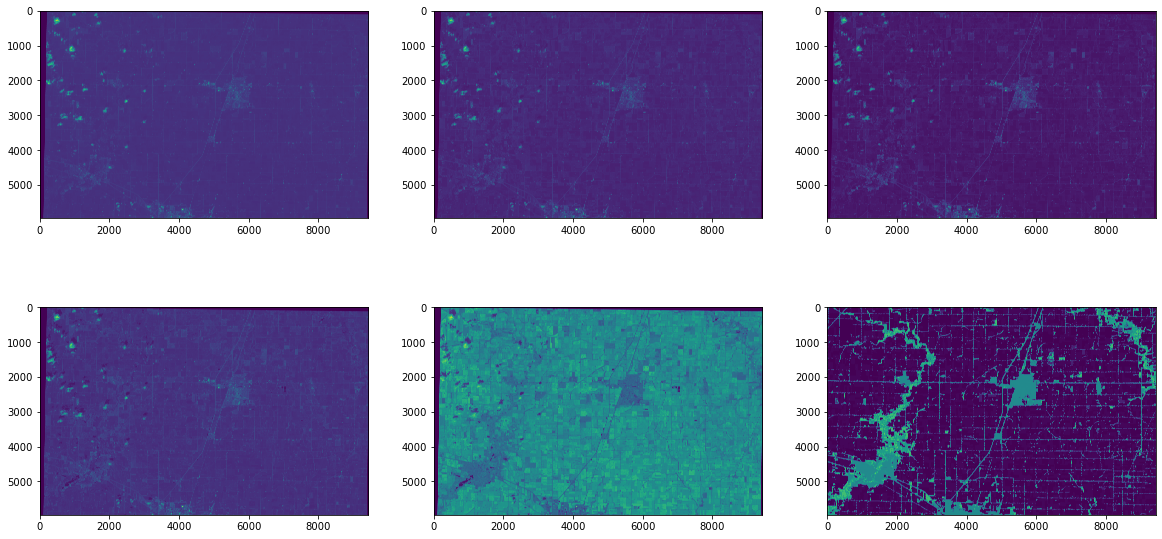

In [101]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for band in range(6):
    ax[band//3][band%3].imshow(fused[band])

**Fuse data, retile, create sets**

In [32]:
data = np.load('./data/raw/north_data.npy')
classes = np.load('./data/raw/north_class.npy')

In [34]:
# Clean class labels
classes = np.where((classes != 1) & (classes != 5), 0, classes)
classes = np.where((classes == 5), 2, classes)
np.unique(classes)

array([0, 1, 2], dtype=uint8)

In [35]:
fused = np.concatenate([data, classes])

In [36]:
def divide_image(image, tile_size, stride):
    tiles = []
    height, width, = image.shape[1], image.shape[2]
    tile_height, tile_width = tile_size
    stride_vertical, stride_horizontal = stride

    for y in range(0, height - tile_height + 1, stride_vertical):
        for x in range(0, width - tile_width + 1, stride_horizontal):
            tile = image[::, y:y+tile_height, x:x+tile_width]
            tiles.append(tile)

    return tiles

In [37]:
tiles = np.array(divide_image(fused, (64, 64), (64, 64)))
np.random.shuffle(tiles)

In [38]:
train_idx = int(0.5 * len(tiles))
size_val = (len(tiles) - train_idx)//2

train_data = tiles[0:train_idx]

valid_data = tiles[train_idx:train_idx+size_val]

test_data = tiles[train_idx+size_val::]

In [39]:
data = {
    'train': train_data.transpose(1, 0, 2, 3),
    'valid': valid_data.transpose(1, 0, 2, 3),
    'test': test_data.transpose(1, 0, 2, 3)
}

for subset, value in data.items():
    with h5py.File(subset + '.hdf5', 'w') as f:
        length = value.shape[1]
        print(length)
        print(value.shape)
        imgs = f.create_dataset('samples', (length, 5, 64, 64), data=value[0:5].transpose(1, 0, 2, 3))
        noisy_imgs = f.create_dataset('labels',(length, 1, 64, 64), data=value[5])


6835
(6, 6835, 64, 64)
3418
(6, 3418, 64, 64)
3418
(6, 3418, 64, 64)


**Test Dataset**

In [40]:
import matplotlib.pyplot as plt
from dataset import *
import numpy as np

In [41]:
train_set = CropDataset(data_path='./data/crop_set/train.hdf5', subset='Train')

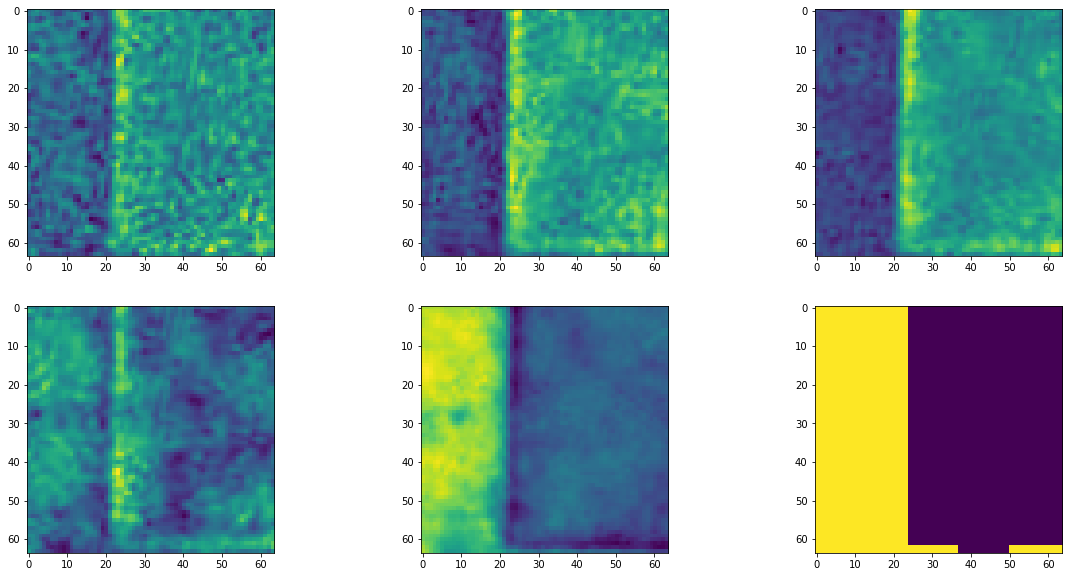

In [42]:
sample, label = train_set[np.random.randint(0, len(train_set))]
sample = np.concatenate([sample, label])
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for band in range(6):
    ax[band//3][band%3].imshow(sample[band])